In [1]:
labels = [{'name':'Hello', 'id':1},
          {'name':'Help', 'id':2},
          {'name':'Hurt', 'id':3},
          {'name':'LoveYou', 'id':4},
          {'name':'No', 'id':5},
          {'name':'One', 'id':6},
          {'name':'Phone', 'id':7},
          {'name':'Please', 'id':8},
          {'name':'ThankYou', 'id':9},
          {'name':'Yes', 'id':10}]

In [2]:
labels

[{'name': 'Hello', 'id': 1},
 {'name': 'Help', 'id': 2},
 {'name': 'Hurt', 'id': 3},
 {'name': 'LoveYou', 'id': 4},
 {'name': 'No', 'id': 5},
 {'name': 'One', 'id': 6},
 {'name': 'Phone', 'id': 7},
 {'name': 'Please', 'id': 8},
 {'name': 'ThankYou', 'id': 9},
 {'name': 'Yes', 'id': 10}]

In [3]:
#creating label maps
with open('Tensorflow/workspace/training_demo/Annotations/label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

In [4]:
#Creating TF Records -- to convert .xml to .record format
!python Tensorflow/scripts/generate_tfrecord.py -x Tensorflow/workspace/training_demo/images/Train -l Tensorflow/workspace/training_demo/Annotations/label_map.pbtxt -o Tensorflow/workspace/training_demo/Annotations/train.record

Successfully created the TFRecord file: Tensorflow/workspace/training_demo/Annotations/train.record


In [5]:
!python Tensorflow/scripts/generate_tfrecord.py -x Tensorflow/workspace/training_demo/images/Test -l Tensorflow/workspace/training_demo/Annotations/label_map.pbtxt -o Tensorflow/workspace/training_demo/Annotations/test.record

Successfully created the TFRecord file: Tensorflow/workspace/training_demo/Annotations/test.record


# Updating the pipeline.config file for the FAST RCNN RESNET Model 

In [6]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format
path="Tensorflow/workspace/training_demo/models/my-fast-rcnn-resnet-model/pipeline.config"
config=config_util.get_configs_from_pipeline_file(path)
#config

In [7]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(path, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [8]:
pipeline_config.model.faster_rcnn.num_classes = 10
pipeline_config.train_config.batch_size = 2
pipeline_config.train_config.fine_tune_checkpoint = 'Tensorflow/workspace/training_demo/pre-trained-models/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= 'Tensorflow/workspace/training_demo/Annotations/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = ['Tensorflow/workspace/training_demo/Annotations/train.record']
pipeline_config.eval_input_reader[0].label_map_path = 'Tensorflow/workspace/training_demo/Annotations/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = ['Tensorflow/workspace/training_demo/Annotations/test.record']

In [9]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(path, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)  

# Training the pretrained resnet model with the custom dataset 

In [ ]:
#This script is to be run on the cmd, to start the training of RCNN-Resnet.

In [ ]:
python Tensorflow/workspace/training_demo/model_main_tf2.py --model_dir=Tensorflow/workspace/training_demo/models/my-fast-rcnn-resnet-model --pipeline_config_path=Tensorflow/workspace/training_demo/models/my-fast-rcnn-resnet-model/pipeline.config --num_train_steps=6000

In [ ]:
#run the above command in cmd

# Load the latest model from the checkpoint

In [1]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file('Tensorflow/workspace/training_demo/models/my-fast-rcnn-resnet-model/pipeline.config')
rcnn_resnet = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=rcnn_resnet)
ckpt.restore(os.path.join('Tensorflow/workspace/training_demo/models/my-fast-rcnn-resnet-model', 'ckpt-11')).expect_partial() #latest model

@tf.function
def detect_fn(image):
    image, shapes = rcnn_resnet.preprocess(image) #to resize the image
    prediction_dict = rcnn_resnet.predict(image, shapes)
    detections = rcnn_resnet.postprocess(prediction_dict, shapes)
    return detections

# Single image detection

INFO:tensorflow:depth of additional conv before box predictor: 0
Instructions for updating:
Use ref() instead.
300
300


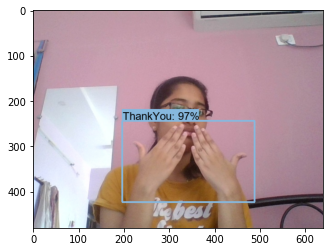

In [3]:
import cv2 
import numpy as np
from win32com.client import Dispatch

from matplotlib import pyplot as plt
%matplotlib inline
category_index = label_map_util.create_category_index_from_labelmap('Tensorflow/workspace/training_demo/Annotations/label_map.pbtxt')
IMAGE_PATH = 'Tensorflow/workspace/training_demo/images/Validation/ThankYou_19.jpg'
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
print (num_detections)
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections #detections regions
print(detections['num_detections'])

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64) #index of the class starting from 0;

image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+1,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

if detections['detection_scores'][0]*100>85:
        speech=(detections['detection_classes']+1)[0]
        speak = Dispatch("SAPI.SpVoice").Speak
        speak(category_index[speech]['name'])
        #print(category_index[speech]['name'])

# To find the model performance

In [ ]:
python Tensorflow/workspace/training_demo/model_main_tf2.py --model_dir=Tensorflow/workspace/trainig_demo/models/my-fast-rcnn-resnet-model --pipeline_config_path=Tensorflow/workspace/training_demo/models/my-fast-rcnn-resnet-model/pipeline.config --checkpoint_dir=Tensorflow/workspace/training_demo/models/my-fast-rcnn-resnet-model/ckpt


<img src="i3.png">

<img src="i4.png">

# Evaluation Metrics

cd E:\Capstone\Tensorflow\workspace\training_demo\models\my-fast-rcnn-resnet-model\eval
tensorboard --logdir=.